## Start your script

Import libraries and fill the empty `base` string with the filepath for your data. Don't forget that Python will require you to double your backslashes -- instead of typing '\\' between folder names, type '\\\\'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter

# Import sklearn functions
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('hr_data(2).csv')
df['Attrition'] = np.where(df['Attrition'] == 'Yes', 1, 0)


## 1.  Plot the Kaplan Meier curve for the `YearsAtCompany` tenure variable for those who have `Attrition = 1` indicating they left the company

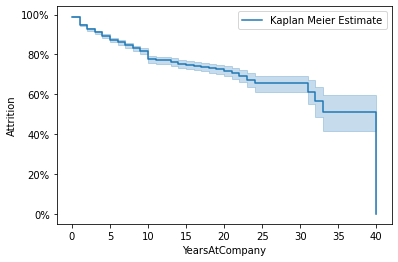

In [2]:
# Create the Kaplan Meier Fitter object
kmf = KaplanMeierFitter()

# Fit the data to the KMF object
kmf.fit(df['YearsAtCompany'], df['Attrition'], label='Kaplan Meier Estimate')
ax = kmf.plot(ci_show=True)
ax.set_xlabel('YearsAtCompany')
ax.set_ylabel('Attrition')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))




## 2. Build a Cox Proportional Hazard model with the employee engagement measures as independent variables.
(*Hint:* The employee engagement variables in this dataset are `EnvironmentSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance`)

In [3]:
cph = CoxPHFitter()
cph.fit(df[['EnvironmentSatisfaction', 'JobSatisfaction','WorkLifeBalance']],
        duration_col='Attrition', event_col='YearsAtCompany')
cph.print_summary()

KeyError: 'Attrition'

## 3. Build a Weibull AFT model with the employee engagement measures as independent variables.
(*Hint:* The employee engagement variables in this dataset are `EnvironmentSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance`)

In [4]:
aft = WeibullAFTFitter()
aft.fit(df[['EnvironmentSatisfaction', 'JobSatisfaction','WorkLifeBalance']],
        duration_col='Attrition', event_col='YearsAtCompany')
aft.print_summary()

KeyError: 'Attrition'

## 4. Create a balanced decision tree model using the employee engagement measures with a `max_depth` of 3 and `random_state` of 123; print the model accuracy
(*Hint:* The employee engagement variables in this dataset are `EnvironmentSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance`)

In [5]:
df.columns
y = df['Attrition']
model_df = df[['EnvironmentSatisfaction', 'JobSatisfaction','WorkLifeBalance']]
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.33,
                                                    random_state=123, stratify=y)

tree = DecisionTreeClassifier(max_depth = 3, random_state=123, class_weight='balanced')
model2 = tree.fit(X_train, y_train)

print('Decision tree node count:', tree.tree_.node_count)
print('Decision tree maximum depth:', tree.tree_.max_depth)
print('Decision tree model accuracy:', tree.score(X_train, y_train))

Decision tree node count: 15
Decision tree maximum depth: 3
Decision tree model accuracy: 0.5220040622884224


## 5. Draw the decision tree that you created in response to Question 4

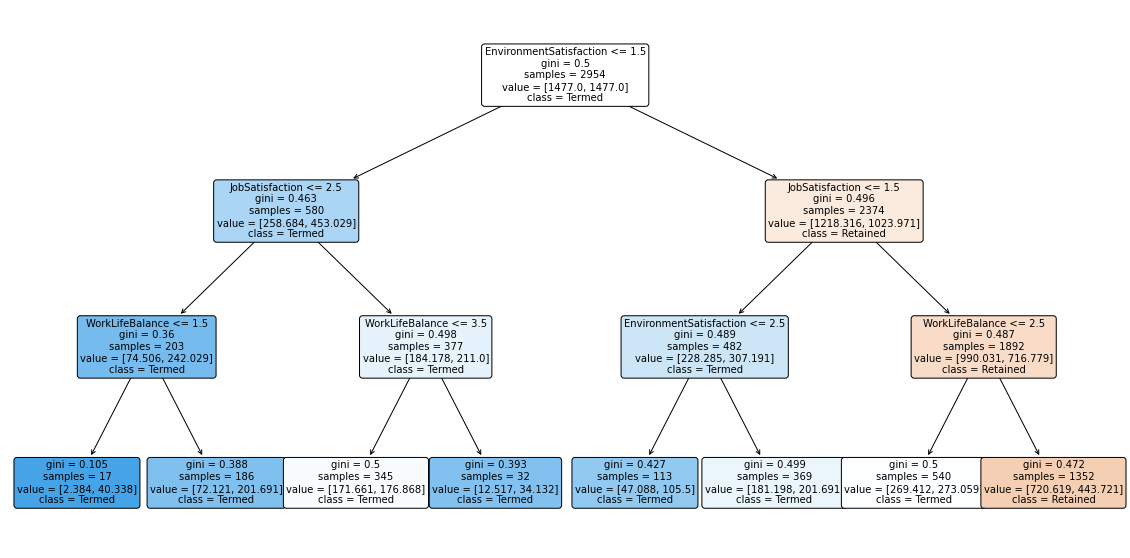

In [6]:
# Draw decision tree
fig, ax = plt.subplots(figsize=(20,10))
plot_tree(model2, feature_names=X_train.columns, class_names=['Retained', 'Termed'],
         filled=True, rounded=True, fontsize=10)
plt.show()


## 6. Create a random forest model using the employee engagement measures with 100 trees and `random_state` of 123; print the model accuracy
(*Hint:* The employee engagement variables in this dataset are `EnvironmentSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance`)

In [23]:
rf_model = RandomForestClassifier(n_estimators=100,
                                 random_state=123,
                                 max_features='sqrt',
                                 n_jobs=-1, verbose=1)

rf_model.fit(X_train, y_train)

n_nodes = []
max_depths = []

for each_tree in rf_model.estimators_:
    n_nodes.append(each_tree.tree_.node_count)
    max_depths.append(each_tree.tree_.max_depth)

print('Average number of nodes:', int(np.mean(n_nodes)))
print('Average maximum depth:', int(np.mean(max_depths)))

# Calculate accuracy on test set
rf_accuracy = rf_model.score(X_test, y_test)
print('Accuracy of classifier on test set: {:.2f}'.format(rf_accuracy))

Average number of nodes: 124
Average maximum depth: 8
Accuracy of classifier on test set: 0.84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## 7. Create a balanced logistic regression model using the employee engagement measures and the `'lbfgs'` solver; print the model accuracy
(*Hint:* The employee engagement variables in this dataset are `EnvironmentSatisfaction`, `JobSatisfaction`, and `WorkLifeBalance`)

In [24]:
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')
logreg.fit(X_train, y_train)


# Look at coefficient estimates
coef_dict = {}
for coef in zip(logreg.coef_[0,:], X_train):
    coef_dict[coef] = coef
print('Coefficient Estimates: ', coef_dict)



Coefficient Estimates:  {(-0.26543808780644623, 'EnvironmentSatisfaction'): (-0.26543808780644623, 'EnvironmentSatisfaction'), (-0.27529365290757724, 'JobSatisfaction'): (-0.27529365290757724, 'JobSatisfaction'), (-0.1926057790712499, 'WorkLifeBalance'): (-0.1926057790712499, 'WorkLifeBalance')}


## 8. Using either the logistic regression model from Question 7 or the random forest model from Question 6, print the model's classification report
(*Hint:* You must first `predict` your y-values using your X-values representing the engagement variables.)

In [18]:

# Used Question 6- Decision Tree
ytrain_pred = rf_model.predict(X_train)
ytrain_prob = rf_model.predict_proba(X_train)[:, 1]

ytest_pred = rf_model.predict(X_test)
ytest_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate accuracy on test set
rf_accuracy = rf_model.score(X_test, y_test)
print('Accuracy of classifier on test set: {:.5f}'.format(rf_accuracy))

# Print classification report
print('\nClassification report:\n', classification_report(y_test, ytest_pred))

Accuracy of classifier on test set: 0.83860

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      1221
           1       0.50      0.06      0.11       235

    accuracy                           0.84      1456
   macro avg       0.67      0.52      0.51      1456
weighted avg       0.79      0.84      0.78      1456



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

## 9. Using either the logistic regression model from Question 7 or the random forest model from Question 6, plot the model's ROC curve
(*Hint:* You must first use `predict` and `predict_proba` using your X-values representing the engagement variables.)

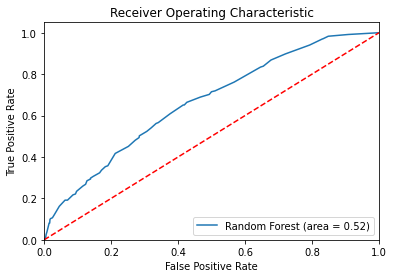

In [21]:
rf_roc_auc = roc_auc_score(y_test, ytest_pred)
fpr, tpr, thresholds = roc_curve(y_test, ytest_prob)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



## 10. Using either the logistic regression model from Question 7 or the random forest model from Question 6, plot the model's confusion matrix as a heatmap